In [2]:
import numpy as np
import tensorflow as tf
from keras.layers import Embedding, Dense, Dropout, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, IntegerLookup, Concatenate, Flatten, Input
import keras_tuner as kt
import pandas as pd
import unicodedata
from matplotlib import pyplot as plt
from keras import metrics
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, \
                            log_loss, precision_recall_curve, roc_auc_score, roc_curve
                            
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import spacy

# Make sure you run this in your terminal
# !python -m spacy download en_core_web_lg
import en_core_web_lg

In [3]:
nlp = en_core_web_lg.load()
Vectorizer = tf.keras.layers.TextVectorization()

In [4]:
features = pd.read_csv('../data/features.csv')
print(features.columns)

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info', 'runtime',
       'runtime_difference_from_average', 'critics_consensus',
       'content_rating', 'original_release_date', 'streaming_release_date',
       'original_release_quarter', 'streaming_release_quarter',
       'original_release_month', 'streaming_release_month',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'oscar_nomination', 'genres_sums',
       'prodComp_sums', 'title_length', 'critic_consensus_length',
       'directors_counts', 'actors_counts', 'actors_value', 'directors_value',
       'action&adventure', 'animation', 'anime&manga',
       'arthouse&international', 'classics', 'comedy', 'cultmovies',
       'documentary', 'drama', 'faith&spirituality', 'gay&lesbian', 'horror',
       'kids&family', 'musical

In [5]:

# Only use the critics consensus for the LSTM
features = features[['critics_consensus', 'title_length', 'critic_consensus_length', 'content_rating', 'runtime_difference_from_average',
       'actors_value', 'directors_value', 'actors_counts', 'directors_counts', 'prodComp_sums', 'genres_sums',
       'original_release_month', 'streaming_release_month',
       'action&adventure', 'animation', 'anime&manga',
       'arthouse&international', 'classics', 'comedy', 'cultmovies',
       'documentary', 'drama', 'faith&spirituality', 'gay&lesbian', 'horror',
       'kids&family', 'musical&performingarts', 'mystery&suspense', 'romance',
       'sciencefiction&fantasy', 'specialinterest', 'sports&fitness',
       'television', 'western',
       'tomatometer_status']]
print(features.columns)

Index(['critics_consensus', 'title_length', 'critic_consensus_length',
       'content_rating', 'runtime_difference_from_average', 'actors_value',
       'directors_value', 'actors_counts', 'directors_counts', 'prodComp_sums',
       'genres_sums', 'original_release_month', 'streaming_release_month',
       'action&adventure', 'animation', 'anime&manga',
       'arthouse&international', 'classics', 'comedy', 'cultmovies',
       'documentary', 'drama', 'faith&spirituality', 'gay&lesbian', 'horror',
       'kids&family', 'musical&performingarts', 'mystery&suspense', 'romance',
       'sciencefiction&fantasy', 'specialinterest', 'sports&fitness',
       'television', 'western', 'tomatometer_status'],
      dtype='object')


In [6]:
# Get rid of all the special characters
features['critics_consensus'] = features['critics_consensus'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8'))

In [7]:
# Apply standard scaling
scaler = StandardScaler()
columns = ['actors_value', 'directors_value', 'runtime_difference_from_average', 'actors_counts', 'directors_counts', 'prodComp_sums', 'genres_sums', 'critic_consensus_length', 'title_length']
features[columns] = scaler.fit_transform(features[columns])

In [8]:
# split data; 60-20-20
X = features.drop(['tomatometer_status'], axis=1)
y = features['tomatometer_status']

# train/test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.2,
                                                    stratify=y, # stratify to equal response %
                                                    random_state=1234,
                                                    shuffle=True)

In [9]:
#fit the vectorizer on the text and extract the corpus vocabulary
Vectorizer.adapt(features.critics_consensus.to_numpy())
vocab = Vectorizer.get_vocabulary()

In [11]:
#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('testing').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    # sometimes word is of type 'numpy.str_' so we must make sure it's a regular string
    word = str(word)
    embedding_matrix[i] = nlp(word).vector

In [12]:
# Set variables
critics_consensus = Input(shape=(1,), dtype='string')
content_rating = Input(shape=(1,), dtype='int64')
runtime_difference_from_average = Input(shape=(1,), dtype='float32')
actors_value = Input(shape=(1,), dtype='float32')
directors_value = Input(shape=(1,), dtype='float32')
release_month = Input(shape=(1,), dtype='int64')
streaming_release_month = Input(shape=(1,), dtype='int64')
actors_counts = Input(shape=(1,), dtype='float32')
director_counts = Input(shape=(1,), dtype='float32')
prodComp_sums = Input(shape=(1,), dtype='float32')
genres_sums = Input(shape=(1,), dtype='float32')
title_length = Input(shape=(1,), dtype='float32')
critic_consensus_length = Input(shape=(1,), dtype='float32')
simple_inputs = [runtime_difference_from_average, actors_value, directors_value, actors_counts, director_counts, prodComp_sums, genres_sums, title_length, critic_consensus_length]

# Genre inputs
action_adventure = Input(shape=(1,), dtype='float32')
animation = Input(shape=(1,), dtype='float32')
anime_manga = Input(shape=(1,), dtype='float32')
arthouse_international = Input(shape=(1,), dtype='float32')
classics = Input(shape=(1,), dtype='float32')
comedy = Input(shape=(1,), dtype='float32')
documentary = Input(shape=(1,), dtype='float32')
drama = Input(shape=(1,), dtype='float32')
faith_spirituality = Input(shape=(1,), dtype='float32')
gay_lesbian = Input(shape=(1,), dtype='float32')
horror = Input(shape=(1,), dtype='float32')
kids_family = Input(shape=(1,), dtype='float32')
musical_performingarts = Input(shape=(1,), dtype='float32')
mystery_suspense = Input(shape=(1,), dtype='float32')
romance = Input(shape=(1,), dtype='float32')
sciencefiction_fantasy = Input(shape=(1,), dtype='float32')
sports_fitness = Input(shape=(1,), dtype='float32')
western = Input(shape=(1,), dtype='float32')

In [13]:
def tune_model(hp):
    lstm_1_units = hp.Int('lstm_1_units', min_value=48, max_value=80, step=4)
    lstm_2_units = hp.Int('lstm_2_units', min_value=24, max_value=48, step=4)
    cc_dense_units = hp.Int('cc_dense_units', min_value=12, max_value=32, step=4)
    dense_1_units = hp.Int('dense_1_units', min_value=12, max_value=20, step=4)
    dense_2_units = hp.Int('dense_2_units', min_value=4, max_value=12, step=4)
    return build_model(lstm_1_units, lstm_2_units, cc_dense_units, dense_1_units, dense_2_units)

def build_model(lstm_1_units=70, lstm_2_units=32, cc_dense_units=20, dense_1_units=16, dense_2_units=12):
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    # Create LSTM layers for critics consensus
    vectorizer_layer = Vectorizer(critics_consensus)
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False
    )(vectorizer_layer)
    lstm_layer = LSTM(lstm_1_units, return_sequences=True)(embedding_layer)
    cc_dropout_1_layer = Dropout(0.3)(lstm_layer)
    lstm_2_layer = LSTM(lstm_2_units, return_sequences=True)(cc_dropout_1_layer)
    pooling_layer = GlobalAveragePooling1D()(lstm_2_layer)
    cc_dropout_3_layer = Dropout(0.3)(pooling_layer)
    cc_dense_layer = Dense(cc_dense_units, activation='sigmoid')(cc_dropout_3_layer)

    # Map release month to an embedding
    month_vocab = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
    release_month_id_layer = IntegerLookup(vocabulary=month_vocab)(release_month)
    release_month_embed_layer = Embedding(len(month_vocab) + 1, 4)(release_month_id_layer)
    release_month_flat_layer = Flatten()(release_month_embed_layer)

    # Map streaming release month to an embedding
    streaming_release_month_id_layer = IntegerLookup(vocabulary=month_vocab)(streaming_release_month)
    streaming_release_month_embed_layer = Embedding(len(month_vocab) + 1, 2)(streaming_release_month_id_layer)
    streaming_release_month_flat_layer = Flatten()(streaming_release_month_embed_layer)

    # Map content rating to an embedding
    content_rating_vocab = [0, 1, 2, 3, 4, 5]
    content_rating_id_layer = IntegerLookup(vocabulary=content_rating_vocab)(content_rating)
    content_rating_embed_layer = Embedding(len(content_rating_vocab) + 1, 2)(content_rating_id_layer)
    content_rating_flat_layer = Flatten()(content_rating_embed_layer)

    # Concat and then calculate embedding for genres
    genre_inputs = [action_adventure, animation, anime_manga, arthouse_international, classics, comedy, documentary, drama, faith_spirituality,
        gay_lesbian, horror, kids_family, musical_performingarts, mystery_suspense, romance, sciencefiction_fantasy, sports_fitness, western]
    genre_concat_layer = Concatenate()(genre_inputs)
    genre_embed_layer = Embedding(len(genre_inputs) + 1, 10)(genre_concat_layer)
    genre_flat_layer = Flatten()(genre_embed_layer)

    concat_layer = Concatenate()([cc_dense_layer, content_rating_flat_layer, *simple_inputs, release_month_flat_layer, streaming_release_month_flat_layer, genre_flat_layer])
                                
    dense_1_layer = Dense(dense_1_units, activation='sigmoid')(concat_layer)
    dropout_layer = Dropout(0.4)(dense_1_layer)
    dense_2_layer = Dense(dense_2_units, activation='sigmoid')(dropout_layer)
    rating_layer = Dense(1, activation='sigmoid')(dense_2_layer)

    model = tf.keras.Model(inputs=[critics_consensus, content_rating, *simple_inputs, release_month, streaming_release_month, *genre_inputs], outputs=rating_layer)

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['binary_accuracy'])

    return model

In [15]:
# The & prevents genres from being accessed as a property
inputs = [
    X_train.critics_consensus,
    X_train.content_rating,
    X_train.runtime_difference_from_average,
    X_train.title_length,
    X_train.critic_consensus_length,
    X_train.actors_value,
    X_train.directors_value,
    X_train.actors_counts,
    X_train.directors_counts,
    X_train.prodComp_sums,
    X_train.genres_sums,
    X_train.original_release_month,
    X_train.streaming_release_month,
    X_train['action&adventure'], X_train['animation'], X_train['anime&manga'], X_train['arthouse&international'],
    X_train['classics'], X_train['comedy'], X_train['documentary'], X_train['drama'], X_train['faith&spirituality'],
    X_train['gay&lesbian'], X_train['horror'], X_train['kids&family'], X_train['musical&performingarts'], X_train['mystery&suspense'],
    X_train['romance'], X_train['sciencefiction&fantasy'], X_train['sports&fitness'], X_train['western'],
]
output = y_train

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
tuner = kt.Hyperband(tune_model,
            objective='val_binary_accuracy',
            max_epochs=10,
            seed=1234,
            project_name='hyperband_tuning',
)

tuner.search(inputs, output, epochs=10, validation_split=0.25, callbacks=[stop_early])
tuner.results_summary(5)

In [16]:
model = build_model()

history = model.fit(inputs,
        output,
        batch_size=16,
        epochs=10,
        validation_split=.2,
        callbacks=[stop_early]
)

train_predictions = model.predict(inputs)

Epoch 1/10
261/261 [==============================] - 12s 30ms/step - loss: 0.6686 - binary_accuracy: 0.5905 - val_loss: 0.5686 - val_binary_accuracy: 0.8119
Epoch 2/10
261/261 [==============================] - 7s 26ms/step - loss: 0.5135 - binary_accuracy: 0.8017 - val_loss: 0.4391 - val_binary_accuracy: 0.8282
Epoch 3/10
261/261 [==============================] - 7s 27ms/step - loss: 0.3956 - binary_accuracy: 0.8565 - val_loss: 0.3641 - val_binary_accuracy: 0.8484
Epoch 4/10
261/261 [==============================] - 7s 27ms/step - loss: 0.3255 - binary_accuracy: 0.8838 - val_loss: 0.3420 - val_binary_accuracy: 0.8570
Epoch 5/10
261/261 [==============================] - 7s 26ms/step - loss: 0.2618 - binary_accuracy: 0.9131 - val_loss: 0.3718 - val_binary_accuracy: 0.8484
Epoch 6/10
163/163 [==============================] - 3s 16ms/step


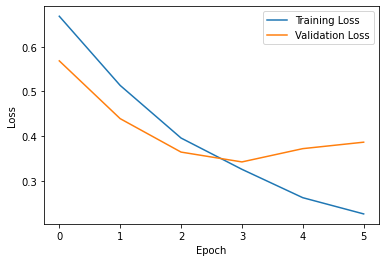

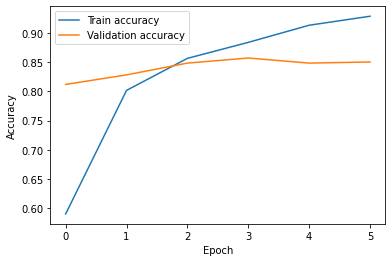

In [17]:
def plot_loss(history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(history['loss'], label='Training Loss')
  plt.plot(history['val_loss'], label='Validation Loss')
  plt.legend()
  plt.show()

plot_loss(history)

def plot_acc(history):
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    train_accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy']
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(val_accuracy, label='Validation accuracy')
    plt.legend()
    plt.show()

plot_acc(history)

In [18]:
# Run the model on the test data
inputs = [
    X_test.critics_consensus,
    X_test.content_rating,
    X_test.runtime_difference_from_average,
    X_test.title_length,
    X_test.critic_consensus_length,
    X_test.actors_value,
    X_test.directors_value,
    X_test.actors_counts,
    X_test.directors_counts,
    X_test.prodComp_sums,
    X_test.genres_sums,
    X_test.original_release_month,
    X_test.streaming_release_month,
    X_test['action&adventure'], X_test['animation'], X_test['anime&manga'], X_test['arthouse&international'],
    X_test['classics'], X_test['comedy'], X_test['documentary'], X_test['drama'], X_test['faith&spirituality'],
    X_test['gay&lesbian'], X_test['horror'], X_test['kids&family'], X_test['musical&performingarts'], X_test['mystery&suspense'],
    X_test['romance'], X_test['sciencefiction&fantasy'], X_test['sports&fitness'], X_test['western'],
]
output = y_test
test_predictions = model.predict(inputs)

41/41 [==============================] - 1s 16ms/step


In [22]:
# Get test accuracy
test_accuracy = tf.keras.metrics.binary_accuracy(output, test_predictions)
print("Test accuracy: %.2f%%" % (test_accuracy*100))

Test accuracy: 86.10%


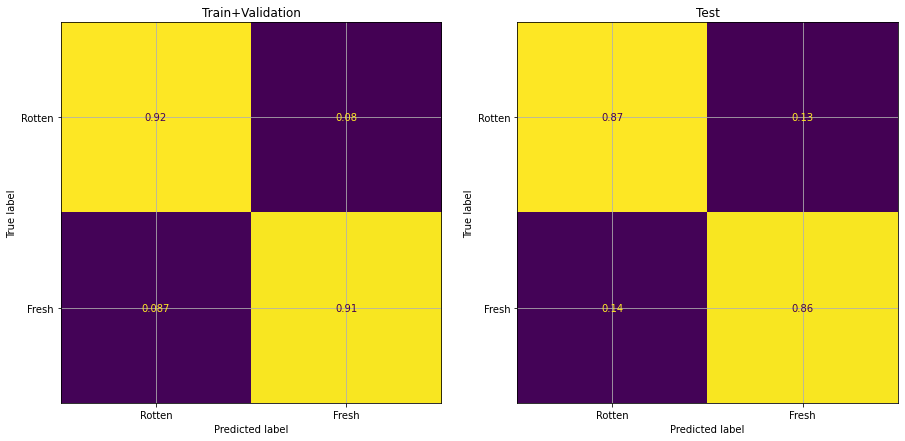

In [20]:
# confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

# Turn predictions into binary 1.0 and 0.0
train_predictions_binary = np.where(train_predictions > 0.5, 1, 0)
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)

cm_train = confusion_matrix(y_train, train_predictions_binary,
                            normalize='true')

cm_test = confusion_matrix(y_test, test_predictions_binary,
                            normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm_train,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_test,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax2, colorbar=False)

ax1.set_title('Train+Validation')
ax2.set_title('Test')
ax1.grid()
ax2.grid()
plt.show()

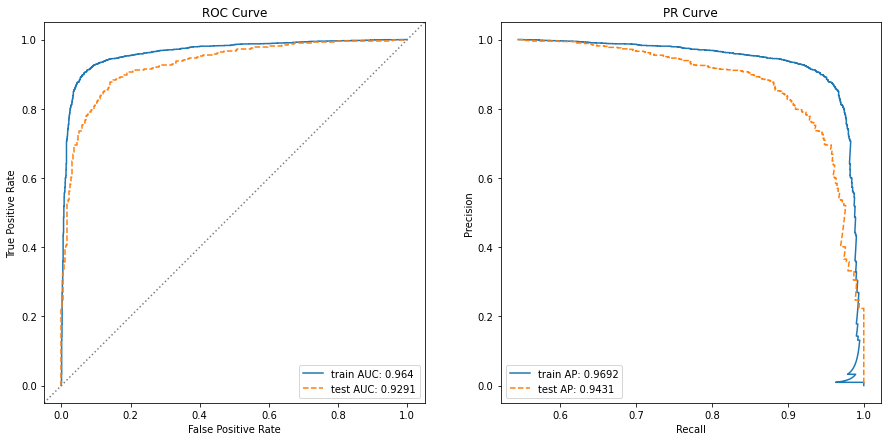

In [21]:
# Plot ROC/AUC curve
# auc
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

train_predictions = train_predictions.ravel()
test_predictions = test_predictions.ravel()

fpr_train, tpr_train, _ = roc_curve(y_train, train_predictions)
fpr_test, tpr_test, _ = roc_curve(y_test, test_predictions)

# pr
prec_train, recall_train, _ = precision_recall_curve(y_train, train_predictions)
prec_test, recall_test, _ = precision_recall_curve(y_test, test_predictions)

ax1.plot(fpr_train, tpr_train, label=f'train AUC: {round(roc_auc_score(y_train, train_predictions), 4)}')
ax1.plot(fpr_test, tpr_test, label=f'test AUC: {round(roc_auc_score(y_test, test_predictions), 4)}', 
         linestyle='--')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, label=f'train AP: {round(average_precision_score(y_train, train_predictions), 4)}')
ax2.plot(prec_test, recall_test, label=f'test AP: {round(average_precision_score(y_test, test_predictions), 4)}', 
         linestyle='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()